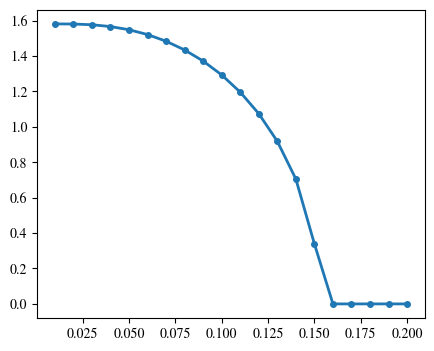

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"

#  
def read_posthoc(npz_path):
    z = np.load(npz_path)
    T   = np.asarray(z["Ts"], float)
    ok  = np.asarray(z["success"], bool)
    d0  = np.asarray(z["d0_re"], float) + 1j*np.asarray(z["d0_im"], float)
    d1  = np.asarray(z["d1_re"], float) + 1j*np.asarray(z["d1_im"], float)
    mu  = np.asarray(z["mu"], float)
    return T, ok, d0,d1,mu

#  
base = "fig3"
V_list = [20]
paths = {V: os.path.join(base, f"V={V}", "posthoc_results.npz") for V in V_list}

#  
fig, ax = plt.subplots(figsize=(5.0, 4))
ax.set_facecolor('none')        # <<< turn off axes background (keep axes/spines)

missing = []
for V in sorted(V_list):
    path = paths[V]
    if not os.path.isfile(path):
        missing.append(path)
        continue

    T, ok, d0,d1,Mu = read_posthoc(path)


    #  
    ax.plot(1000*T[ok], np.abs(1000*d0[ok]), label=fr"$|V|={V}$", lw=2, marker="o", ms=4)

    #  
    if (~ok).any():
        ax.plot(1000*T[~ok], np.abs(1000*d0[~ok]), "x", alpha=0.35, ms=5)

In [8]:

        
import os
import glob
import numpy as np
import re 

def load_flatpack(k_index, flat_dir="lambda_flat_triplet"):
    path = os.path.join(flat_dir, f"flat_k{k_index:05d}.npz")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Not found: {path}")
    z = np.load(path, allow_pickle=True)
    return {
        "L0flat": z["L0flat"],           
        "L1flat": z["L1flat"],           
        "Eplus_flat":  z["Eplus_flat"], 
        "Eminus_flat": z["Eminus_flat"], 
        "flat_plus_idx":  z["flat_plus_idx"],    
        "flat_minus_idx": z["flat_minus_idx"],  
        "k": z["k"], "k_index": int(z["k_index"])
    }

def flat_BdG(pack, *,DeltaLayer0, DeltaLayer1,mu):
    #
    Δ0 = np.asarray(DeltaLayer0, complex).ravel()
    Δ1 = np.asarray(DeltaLayer1, complex).ravel()
    if Δ0.size != 3 or Δ1.size != 3:
        raise ValueError("DeltaLayer0/1 must each have length 3.")
    # 
    
    Fp = np.diag(np.asarray(pack["Eplus_flat"], float))     # (2,2)
    Fm = -np.diag(np.asarray(pack["Eminus_flat"], float))   # (2,2)

    #  
    L0flat = np.asarray(pack["L0flat"])
    L1flat = np.asarray(pack["L1flat"])
    #
    Gap_flat = sum(Δ0[s] * np.conj(L0flat[s]) + Δ1[s] * np.conj(L1flat[s]) for s in (0,))
    ###  
    I = np.eye(Fp.shape[0], dtype=complex)
    HLL = np.block([
        [Fp-mu*I,            Gap_flat        ],
        [Gap_flat.conj().T,   Fm+mu*I        ]
    ]).astype(complex)
    return HLL, Gap_flat


def delta(x,sigma):
    return np.exp(-0.5*(x/sigma)**2) / (np.sqrt(2*np.pi)*sigma)

def thermal_delta(x, T):
 
    x = np.asarray(x, dtype=float)
    T = float(T)
    y = x / (2.0*T)
    # sech^2(y) = 1 / cosh(y)^2 is stable even for large |y|
    return (1.0 / (4.0*T)) * (1.0 / np.cosh(y)**2)


def DOS(pack, *, omega,DeltaLayer0, DeltaLayer1,mu):
    #
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
    E, U = np.linalg.eigh(HLL)
    #sigma=5e-5;
    #t = thermal_delta(omega-E,sigma)  
    sigma=2e-5;
    t = delta(omega-E,sigma)  
    G = (U * t) @ U.conj().T                 
    F = np.trace(G[0:2, 0:2] )                                   
    return F

 
def Sum_DOS(*,omega, DeltaLayer0, DeltaLayer1, mu, flat_dir="lambda_flat_singlet", average=True):
    #
    files = sorted(fn for fn in os.listdir(flat_dir) if re.match(r"flat_k\d{5}\.npz$", fn))
    if not files:
        raise FileNotFoundError(f"No flat_kXXXXX.npz files found in {flat_dir}")
    acc0 = 0j; acc1 = 0j; Nk = 0
    for fn in files:
        pack = load_flatpack(int(fn[6:11]), flat_dir=flat_dir)
        F  = DOS(pack,omega=omega, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
        acc0 += F   #
        Nk += 1
    if average and Nk:
        acc0 /= Nk;
    return acc0

In [9]:
 
sym=0;
Δ0_vec = np.zeros(3, complex); Δ1_vec = np.zeros(3, complex);
  
#  
ReDOS = []
for i in range(d0.size):
    Δ0_vec[sym] = d0[i]; Δ1_vec[sym] = d1[i];
    mua=Mu[i];
    acc0 = Sum_DOS(
        omega=0,
        DeltaLayer0=Δ0_vec,
        DeltaLayer1=Δ1_vec,
        mu=mua,
        flat_dir="lambda_flat_singlet",
        average=True
    )
    ReDOS.append(np.real(acc0))

ReDOS = np.array(ReDOS )

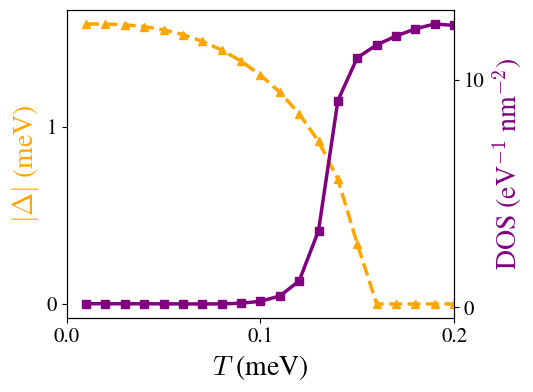

In [11]:
#  
fig, ax = plt.subplots(figsize=(5, 4))

# 
# 
l1, = ax.plot(1000*T,  1000*np.abs(d0), "^--",color="orange", lw=2.5, ms=6, label=r"$|\Delta|$")
ax.set_xlabel(r"$T$ (meV)", fontsize=20)
ax.set_ylabel(r"$|\Delta|$ (meV)", fontsize=20,color="orange")
ax.tick_params(labelsize=15)

# 
ax2 = ax.twinx()
m1, = ax2.plot(1000*T, ReDOS*0.2/(2*np.pi)**2, "s-", lw=2.5, ms=5.5, label=r"DOS",color="purple")
ax2.set_ylabel(r"DOS (eV$^{-1}$ nm$^{-2}$)", fontsize=20,color="purple")
ax2.tick_params(labelsize=15)

#  
ax.set_xlim(1000*T.min(), 1000*T.max())

#  
handles = [ l1, m1]
labels  = [h.get_label() for h in handles]
# 

#  
ref=1.46

ax.set_xticks([0,0.1,0.2])     # x ticks for V
ax.set_yticks([0.0, 1])     # left y ticks for |Δ|
ax2.set_yticks([0,10] ) 
 
plt.savefig("figs/fig7.pdf", bbox_inches="tight")

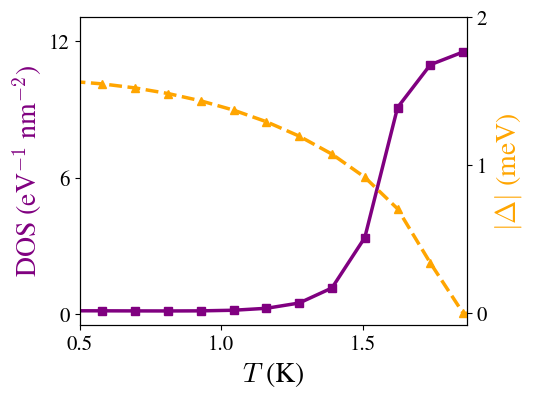

In [34]:
#  
fig, ax = plt.subplots(figsize=(5, 4))

#  
# 
m1, = ax.plot(1000*T*11.6, ReDOS*0.2/(2*np.pi)**2, "s-", lw=2.5, ms=5.5, label=r"DOS",color="purple")

ax.set_xlabel(r"$T$ (K)", fontsize=20)

ax.set_ylabel(r"DOS (eV$^{-1}$ nm$^{-2}$)", fontsize=20,color="purple")
ax.tick_params(labelsize=15)

ax.set_yticks([0,6,12]) 
# 
ax2 = ax.twinx()
l1, = ax2.plot(1000*T*11.6,  1000*np.abs(d0), "^--",color="orange", lw=2.5, ms=6, label=r"$|\Delta|$")
ax2.set_xlabel(r"$T$ (meV)", fontsize=20)
ax2.set_ylabel(r"$|\Delta|$ (meV)", fontsize=20,color="orange")
ax2.tick_params(labelsize=15)


ref=1.46

ax2.set_xticks([0.5,1,1.5])     # x ticks for V
ax2.set_yticks([0,1.0,2])     # left y ticks for |Δ|
ax2.set_xlim(0.5, 1.87)
 

plt.savefig("figs/fig7U.pdf", bbox_inches="tight")